# CS4248 Project Group 23

In [ ]:
# If you wish to run this on Google Colab, mount the Google drive by running this cell or click the `files` icon on the left navbar
# and click mount Google Drive (it takes some time to load)
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/CS4248_BERT.ipynb"
!cd "/content/drive/My Drive/CS4248_BERT.ipynb"

In [ ]:
!pip show transformers

In [ ]:
!pip install --upgrade transformers

In [3]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np

In [33]:
from sklearn.utils import resample

train = pd.read_csv("/kaggle/input/raw-data/raw_data/raw_data/fulltrain.csv", names=['Verdict', 'Text'])

minority_class = train[train['Verdict'] == 4]
majority_class = train[train['Verdict'] != 4]

# Downsample the majority class
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combine the downsampled majority class with the minority class
balanced_data = pd.concat([majority_downsampled, minority_class])

In [8]:
from transformers import BertTokenizer

seq_len = 512
num_samples = len(balanced_data)
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))    #attention mask


In [36]:
print(len(balanced_data[balanced_data['Verdict'] ==4]))
print(len(balanced_data[balanced_data['Verdict'] ==1]) + len(balanced_data[balanced_data['Verdict'] ==2])+ len(balanced_data[balanced_data['Verdict'] ==3]))
print(len(balanced_data))

9995
9995
19990


In [15]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


for i, text in enumerate(balanced_data['Text']):
    tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

2024-04-12 20:15:52.604080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 20:15:52.604154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 20:15:52.605677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
np.savetxt('Xids_2classes_downsampledv2.txt', Xids)
np.savetxt('Xmask_2classes_downsampledv2.txt', Xmask)

In [ ]:
#to load saved tokens
Xids = np.loadtxt("/kaggle/input/raw-data/Xids_2classes_downsampledv2.txt")
Xmask = np.loadtxt("/kaggle/input/raw-data/Xmask_2classes_downsampledv2.txt")

In [ ]:
Xids.shape

In [37]:
y_train = balanced_data['Verdict'].values.copy()
y_train[y_train != 4] = 0
y_train[y_train == 4] = 1
y_labels = np.zeros((num_samples, y_train.max()+1))
y_labels[np.arange(num_samples), y_train] = 1   #one-hot encoding of the labels

In [40]:
print(y_labels)
print(y_labels.shape)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(19990, 2)


In [41]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, y_labels))
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [42]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels    #create a tuple of dictionaries

dataset = dataset.map(map_func)
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [43]:
batch_size = 16
dataset = dataset.shuffle(num_samples).batch(batch_size, drop_remainder=True) #shuffle the data, then batch it and drop remainder if any
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))>

In [44]:
split = 0.9
size = int((num_samples / batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

del dataset

Test out different kinds of models and find the most effective architectures.|

In [45]:
from transformers import TFBertModel

bert = TFBertModel.from_pretrained('bert-base-uncased')
bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
#input layers with the shape of seq_len
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# create embeddings from bert
embeddings = bert.bert(input_ids, attention_mask=mask)[1]   #extracting the pooled layer of 3D tensors pulled into 2D

x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
# dropout_output = tf.keras.layers.Dropout(rate=0.1)(x)
y = tf.keras.layers.Dense(y_train.max()+1, activation='softmax', name='outputs')(x)

In [47]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
# model.layers[2].trainable=False   #freeze the training of the bert layer
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [ ]:
from keras.losses import binary_crossentropy, categorical_crossentropy
import keras.backend as K
import numpy as np
from prettytable import PrettyTable
from prettytable import ALL
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
tf.experimental.numpy.experimental_enable_numpy_behavior()

def f1(y_true, y_pred):
    y_pred = tf.math.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.math.reduce_mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [48]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-6)
# loss = tf.keras.losses.CategoricalCrossentropy()
# acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

#metrics=[tf.keras.metrics.F1Score(average='macro', threshold=None, name='f1_score', dtype=None)])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-6),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.BinaryAccuracy('accuracy'), tf.keras.metrics.F1Score(average='macro', threshold=None, name='f1_score', dtype=None) ])

In [49]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=3
)
model.save('BERT_Model')

Epoch 1/3


I0000 00:00:1712954382.396107   54220 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1124/1124 [==============================] - 1325s 1s/step - loss: 0.3260 - accuracy: 0.8483 - f1_score: 0.8482 - val_loss: 0.2294 - val_accuracy: 0.8940 - val_f1_score: 0.8936
Epoch 2/3
1124/1124 [==============================] - 1227s 1s/step - loss: 0.1284 - accuracy: 0.9497 - f1_score: 0.9497 - val_loss: 0.0965 - val_accuracy: 0.9610 - val_f1_score: 0.9608
Epoch 3/3
1124/1124 [==============================] - 1227s 1s/step - loss: 0.0706 - accuracy: 0.9748 - f1_score: 0.9748 - val_loss: 0.0807 - val_accuracy: 0.9690 - val_f1_score: 0.9690


In [ ]:
model = tf.keras.models.load_model('/kaggle/input/bert-model')

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


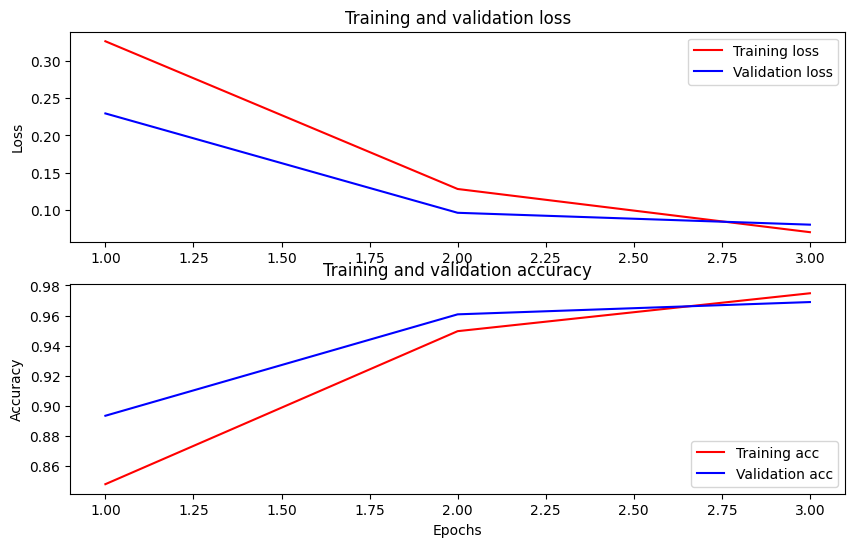

In [51]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['f1_score']
val_acc = history_dict['val_f1_score']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Testing

In [52]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def preprocess_text_with_bert(text):
    tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_tensors='tf')

    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)
    }

In [53]:
test = pd.read_csv("/kaggle/input/raw-data/raw_data/raw_data/balancedtest.csv", names=['Label', 'Text'])

y_pred = np.zeros(len(test), dtype=int)
for i, text in enumerate(test['Text']):
    probs = model.predict(preprocess_text_with_bert(text))
#     print(probs.shape)
#     print(probs)
#     print(probs[0])
    y_pred[i] = np.argmax(probs[0])

1/1 [==============================] - 0s 64ms/step


In [57]:
np.savetxt('y_pred.txt', y_pred)

In [54]:
y_pred

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
y_pred = np.loadtxt('/kaggle/input/raw-data/y_pred (1).txt')

In [56]:
y_test = test['Label'].values.copy() # subtract 1 to make the labels 0-based
y_test[y_test != 4] = 0
y_test[y_test == 4] = 1 # 1,2,3 -> 0 (unreliable news), 4 -> 1 (reliable news)
# get the f1 score
f1_score_test = f1_score(y_test, y_pred, average='macro')
print(f1_score_test)

0.7541793033801945


References: <br>
James Briggs: https://www.youtube.com/watch?v=pjtnkCGElcE <br>
Tensor Flow Documentation: https://www.tensorflow.org/text/tutorials/classify_text_with_bert <br>
Balancing datasets: https://medium.com/@tam.tamanna18/handling-imbalanced-datasets-in-python-methods-and-procedures-7376f99794de